In [42]:
# conda install theano
!pip install mkl
!pip install theano

# import pymc as pm
# !pip install --upgrade pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
pm.__version__

'5.3.1'

In [20]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [21]:
df = pd.read_csv('student2mat.csv')
# print(df)
print(df.shape)
df.head()

(395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [22]:
# lets remove all those rows that scored 0 or 1 G3 
df['G3'].isin([0,1])
# print(df['G3'].isin([0,1]).shape)
df = df[~df['G3'].isin([0,1])]
print(df.shape)

(357, 33)


In [23]:
df = df.rename(columns={'G3':'Grade'})

In [24]:
# finding correlation matrix
df.corr()['Grade'].abs().sort_values()

freetime      0.021589
famrel        0.037711
health        0.081691
traveltime    0.099785
studytime     0.126728
age           0.140372
Dalc          0.140690
Fedu          0.158811
goout         0.177383
Walc          0.190054
Medu          0.190308
absences      0.213129
failures      0.293831
G1            0.891805
G2            0.965583
Grade         1.000000
Name: Grade, dtype: float64

In [25]:
dummy_df=pd.get_dummies(df)
dummy_df['Grade']=df['Grade']
dummy_df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,3,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0


In [26]:
dummy_df.corr()['Grade'].abs().sort_values()

reason_home          0.000372
reason_other         0.003897
Fjob_health          0.006241
guardian_mother      0.007728
Fjob_services        0.018154
freetime             0.021589
nursery_no           0.026541
nursery_yes          0.026541
Pstatus_A            0.026665
Pstatus_T            0.026665
paid_no              0.028899
paid_yes             0.028899
Fjob_at_home         0.028954
guardian_father      0.035220
famrel               0.037711
famsize_LE3          0.039744
famsize_GT3          0.039744
Mjob_teacher         0.045390
romantic_yes         0.049944
romantic_no          0.049944
reason_course        0.050918
reason_reputation    0.056573
activities_yes       0.058600
activities_no        0.058600
famsup_no            0.067305
famsup_yes           0.067305
guardian_other       0.069491
Fjob_other           0.081502
health               0.081691
school_MS            0.083615
school_GP            0.083615
Mjob_at_home         0.090624
traveltime           0.099785
Mjob_servi

In [27]:
# now, make data more useful and delete unnecesaary colomns
def format_data(df):
    df=df.drop(columns=['school','G1','G2'])
    df=pd.get_dummies(df)
    labels = df['Grade']   # y
    most_correlated = df.corr().abs()['Grade'].sort_values(ascending=False)
    most_correlated = most_correlated[:8]
    df = df.loc[:, most_correlated.index]
    df = df.rename(columns={'schoolsup_no':'higher_yes','Walc':'studytime', 'goout':'Fedu'})
    
    df = df.drop(columns = ['schoolsup_yes'])
    X_train, X_test, y_train, y_test = train_test_split(df, labels,test_size = 0.25,random_state=50)
    return X_train,X_test,y_train,y_test

In [28]:
X_train,X_test,y_train,y_test = format_data(df)

In [29]:
X_train.head()

,Grade,failures,higher_yes,absences,Medu,studytime,Fedu
195,15,0,1,0,2,1,2
384,5,1,1,14,4,3,3
253,8,0,1,0,2,3,2
102,14,0,1,4,4,1,3
48,14,0,1,2,4,2,3


In [30]:
X_train = X_train.rename(columns={'higher_yes': 'higher_edu', 
                                  'Medu': 'mother_edu',
                                  'Fedu': 'father_edu'})

X_test = X_test.rename(columns={'higher_yes': 'higher_edu', 
                                  'Medu': 'mother_edu',
                                  'Fedu': 'father_edu'})
X_train.head()

,Grade,failures,higher_edu,absences,mother_edu,studytime,father_edu
195,15,0,1,0,2,1,2
384,5,1,1,14,4,3,3
253,8,0,1,0,2,3,2
102,14,0,1,4,4,1,3
48,14,0,1,2,4,2,3


In [31]:
def evaluate(X_train, X_test, y_train, y_test):
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    X_train = X_train.drop(columns='Grade')
    X_test = X_test.drop(columns='Grade')
    
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        

        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
    
    
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    return results

In [32]:
res = evaluate(X_train,X_test,y_train,y_test)
print(res)

                            mae      rmse
Linear Regression        2.3257  2.874959
ElasticNet Regression  2.567388  3.141147
Random Forest          2.434527  2.967464
Extra Trees            2.593352  3.168927
SVM                     2.32368  2.897231
Gradient Boosted       2.388462  2.917678
Baseline               2.611111  3.277872


In [33]:
formula = 'Grade ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
formula

'Grade ~ failures + higher_edu + absences + mother_edu + studytime + father_edu'

In [73]:
# import pymc as pm

# with pm.Model() as normal_model:
#     intercept = pm.Normal('intercept', mu=0, sigma=10)
#     coefficients = pm.Normal('coefficients', mu=0, sigma=10, shape=X_train.shape[1])
    
#     mean = intercept + pm.math.dot(X_train, coefficients)
    
#     precision = pm.Gamma('precision', alpha=0.1, beta=0.1)
    
#     obs = pm.Normal('obs', mu=mean, sigma=pm.math.sqrt(1 / precision), observed=y_train)
    
#     normal_trace = pm.sample(draws=2000, tune=500, chains=2)
#     normal_trace = normal_trace[1000:]
# import pymc as pm
# import arviz as az

# with pm.Model() as normal_model:
#     intercept = pm.Normal('intercept', mu=0, sigma=10)
#     coefficients = pm.Normal('coefficients', mu=0, sigma=10, shape=X_train.shape[1])
    
#     mean = intercept + pm.math.dot(X_train, coefficients)
    
#     precision = pm.Gamma('precision', alpha=0.1, beta=0.1)
    
#     obs = pm.Normal('obs', mu=mean, sigma=pm.math.sqrt(1 / precision), observed=y_train)
    
#     # normal_trace = pm.sample(draws=2000, tune=500, chains=2)
#     # normal_trace = az.from_pymc3(normal_trace)
#     # normal_trace = az.slice(normal_trace, start=1000)
#     normal_trace = pm.sample(draws=2000, chains = 2, tune = 500)
#     print(normal_trace)

# import pymc3 as pm
# import pymc3 as pm
import numpy as np

with pm.Model() as normal_model:
    # Define priors
    intercept = pm.Normal('Intercept', mu=0, sigma=10)
    coefficients = []
    for i, variable in enumerate(X_train.columns[1:]):
        coefficients.append(pm.Normal('coeff_%d' % i, mu=0, sigma=10))
    
    # Define likelihood
    formula = 'Grade ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
    mu = intercept
    for i, variable in enumerate(X_train.columns[1:]):
        mu += coefficients[i] * X_train[variable]
    sigma = pm.Exponential('sigma', lam=1)
    grade = pm.Normal('Grade', mu=mu, sigma=sigma, observed=y_train)
    
    # Perform inference
    normal_trace = pm.sample(draws=2000, chains=2, tune=500)
    # normal_trace = normal_trace[1000:]


    # normal_trace = normal_trace[1000:]
# normal_trace = az.slice(normal_trace, start=1000)

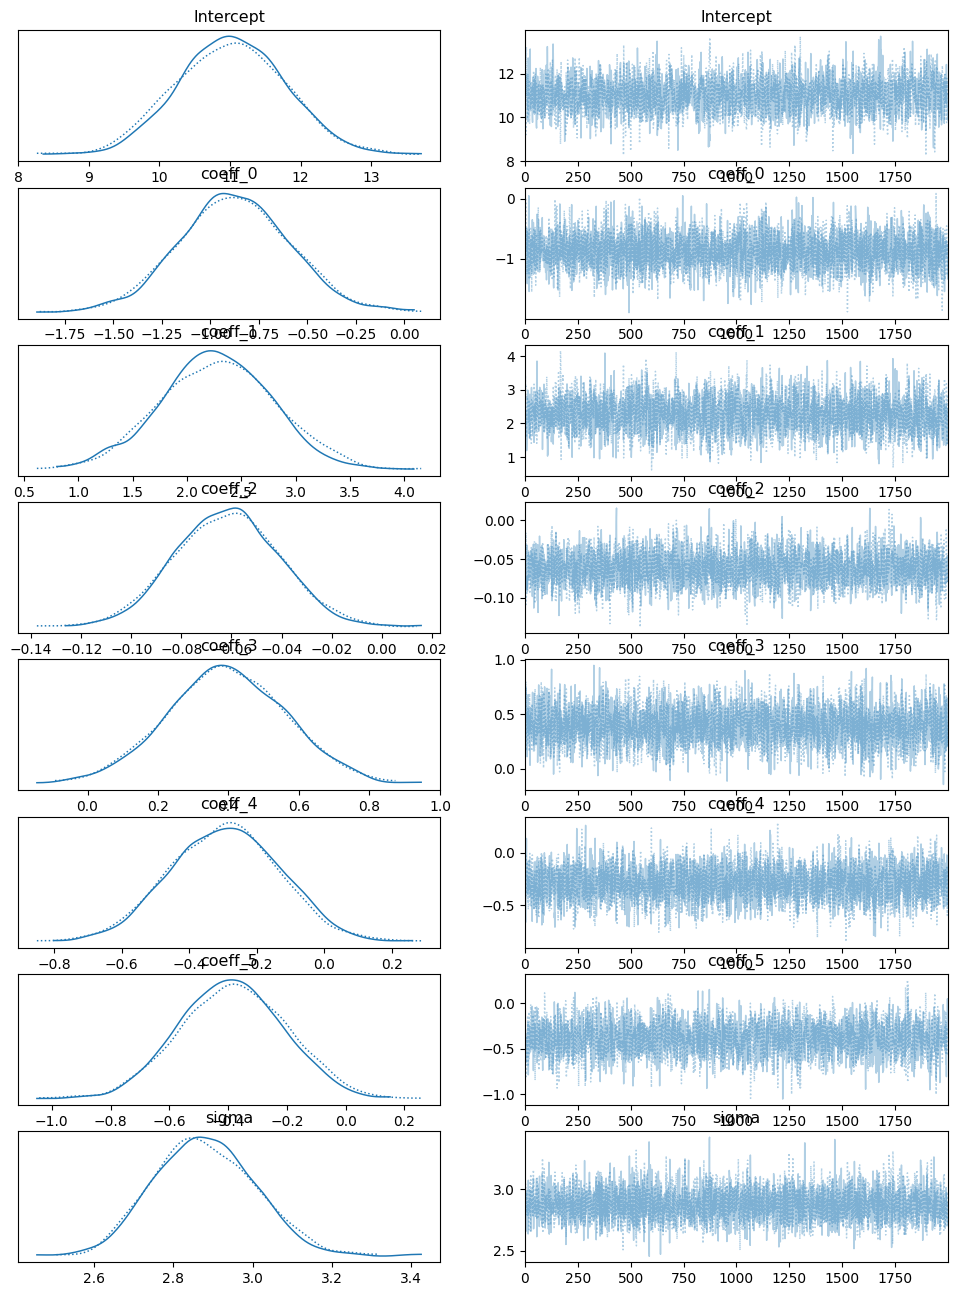

In [74]:
pm.plot_trace(normal_trace);

In [96]:
print(normal_trace)
print(normal_trace.posterior)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
<xarray.Dataset>
Dimensions:    (chain: 2, draw: 2000)
Coordinates:
  * chain      (chain) int64 0 1
  * draw       (draw) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    Intercept  (chain, draw) float64 11.31 10.37 12.1 ... 11.68 11.06 11.05
    coeff_0    (chain, draw) float64 -1.668 -0.4213 -1.351 ... -0.8132 -0.9142
    coeff_1    (chain, draw) float64 1.89 3.344 1.314 ... 2.854 2.505 2.626
    coeff_2    (chain, draw) float64 -0.09308 -0.01744 ... -0.07781 -0.07981
    coeff_3    (chain, draw) float64 0.1701 0.4576 0.2311 ... 0.1932 0.419 0.446
    coeff_4    (chain, draw) float64 -0.05362 -0.4304 ... -0.2139 -0.1559
    coeff_5    (chain, draw) float64 -0.2043 -0.5546 -0.2856 ... -0.5727 -0.5113
    sigma      (chain, draw) float64 2.791 2.883 2.88 ... 2.911 2.982 2.941
Attributes:
    created_at:                 2023-05-21T10:24:19.970938
    arviz_version:              0.12.